**File name**: main.ipynb<br>
**Author**: Anton Karazeev &lt;[anton.karazeev@gmail.com](mailto:anton.karazeev@gmail.com)&gt;<br>
This file is part of REDE project (https://github.com/akarazeev/REDE)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
%load_ext autoreload
%autoreload 2

from utils.dataset import REDE

In [4]:
train_dataset = REDE('data/rede', train=True, transform=torchvision.transforms.ToTensor(),
                     download=True, test_size=0.2)
train_dataset

Processing...
Done!


Dataset REDE
    Number of datapoints: 844
    Split: train (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x10e485400>

In [5]:
test_dataset = REDE('data/rede', train=False, transform=torchvision.transforms.ToTensor(),
                   download=True, test_size=0.2, test_indices=train_dataset.test_indices)
test_dataset

Dataset REDE
    Number of datapoints: 212
    Split: test (test_size: 0.2)
    Root Location: data/rede
    Transforms (if any): <torchvision.transforms.ToTensor object at 0x1103fea58>

In [6]:
BATCH = 10
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH)

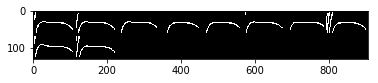

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Function to show an image.
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, parameters = dataiter.next()

# Show images.
imshow(torchvision.utils.make_grid(images))

In [8]:
# Corresponding parameters of simulated models -
# (gap, width1, height, radius1, width2).
parameters


1.00000e-05 *
  0.0400  0.1550  0.0700  2.0000  0.1000
  0.0250  0.1450  0.0800  2.2000  0.1000
  0.0300  0.1450  0.0800  1.8000  0.0880
  0.0250  0.1450  0.0750  1.8000  0.0800
  0.0300  0.1550  0.0700  1.8000  0.0880
  0.0400  0.1450  0.0700  2.0000  0.0920
  0.0350  0.1550  0.0750  1.8000  0.0840
  0.0250  0.1500  0.0700  2.2000  0.0920
  0.0350  0.1500  0.0800  2.0000  0.0960
  0.0250  0.1550  0.0850  2.0000  0.0920
[torch.FloatTensor of size 10x5]

In [9]:
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 3, 5, stride=2),
            nn.MaxPool2d(5, 1),
            nn.Conv2d(3, 5, 3, stride=1),
            nn.MaxPool2d(3, 1),
            nn.ReLU(True),
            nn.Conv2d(5, 2, 3, stride=1),
            nn.MaxPool2d(2, 2)
        )
        self.head = nn.Linear(396, 5)

    def forward(self, x):
        x = self.encoder(x)
        return self.head(x.view(x.size(0), -1))

criterion = nn.MSELoss()

# Train

In [10]:
def test_net(net):
    """Function helps to calculate loss on test dataset."""
    test_loss = 0
    for data in test_loader:
        
        inputs, labels = data
        labels = labels * 1e7

        inputs, labels = Variable(inputs), Variable(labels)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.data[0]
    return test_loss

# Training loop

In [11]:
%%time

EPOCH = 10  # Total number of epochs to train.
LR = 0.0001  # Initial learning rate.

net = Net()
optimizer = optim.Adam(net.parameters(), LR)

print_each = 30  # Print training loss every `print_each` iteration.
test_each = 2    # Print testing loss every `test_each` epoch.
reduce_lr = 4    # Reduce `LR` by 2 every `reduce_lr` epoch.

curtimestep = 0
test_steps = []
test_losses = []
train_steps = []
train_losses = []

for epoch in range(EPOCH):  # Loop over the dataset multiple times.
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        for param_group in optimizer.param_groups:
            param_group['lr'] = LR
        
        # Get the inputs.
        inputs, parameters = data
        parameters = parameters * 1e7

        # Wrap them in Variable.
        inputs, parameters = Variable(inputs), Variable(parameters)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward -> backward -> optimize.
        outputs = net(inputs)
        loss = criterion(outputs, parameters)
        loss.backward()
        optimizer.step()
        
        # Add loss per element.
        running_loss += loss.data[0] / len(parameters)
        
        curtimestep += 1
        
        # Print statistics.
        if i % print_each == print_each - 1:
            loss_per_element = running_loss / print_each
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss_per_element))
            
            train_losses.append(loss_per_element)
            train_steps.append(curtimestep)
            running_loss = 0.0

    # Calculate loss on test dataset.
    if epoch % test_each == test_each - 1:
        test_loss = test_net(net)
        test_loss /= len(test_dataset)
        print('[%d] Test loss: %.3f' % (epoch + 1, test_loss))
        print('LR: {}'.format(LR))
        
        test_losses.append(test_loss)
        test_steps.append(curtimestep)
    
    # Reduce LR by 2 every `reduce_lr` epoch.
    if epoch % reduce_lr == reduce_lr - 1:
        LR /= 2.

print('Finished Training')

[1,    30] loss: 899.350
[1,    60] loss: 893.071
[2,    30] loss: 879.784
[2,    60] loss: 856.224
[2] Test loss: 861.693
LR: 0.0001
[3,    30] loss: 783.209
[3,    60] loss: 709.453
[4,    30] loss: 510.782
[4,    60] loss: 365.087
[4] Test loss: 191.473
LR: 0.0001
[5,    30] loss: 146.987
[5,    60] loss: 97.366
[6,    30] loss: 41.407
[6,    60] loss: 24.547
[6] Test loss: 16.336
LR: 5e-05
[7,    30] loss: 10.906
[7,    60] loss: 8.322
[8,    30] loss: 6.577
[8,    60] loss: 6.582
[8] Test loss: 7.780
LR: 5e-05
[9,    30] loss: 6.208
[9,    60] loss: 6.465
[10,    30] loss: 6.179
[10,    60] loss: 6.450
[10] Test loss: 7.654
LR: 2.5e-05
Finished Training
CPU times: user 11.3 s, sys: 1.85 s, total: 13.2 s
Wall time: 12.4 s


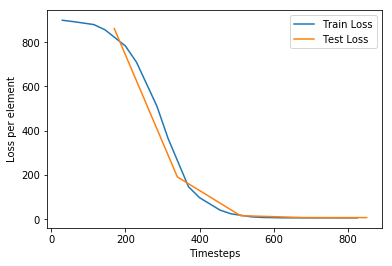

In [12]:
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(test_steps, test_losses, label='Test Loss')
plt.xlabel('Timesteps')
plt.ylabel('Loss per element')
plt.legend()
plt.show()

# Test

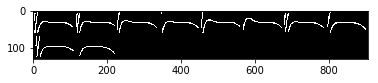

In [13]:
# Get some random testing images.
dataiter = iter(test_loader)
images, parameters = dataiter.next()

# Print images.
imshow(torchvision.utils.make_grid(images))

In [14]:
parameters * 1e7


   3.0000   15.5000    8.0000  220.0000    9.2000
   3.5000   15.5000    8.0000  220.0000    8.8000
   3.5000   14.5000    8.0000  220.0000    9.6000
   3.0000   15.5000    8.0000  180.0000    9.2000
   4.0000   14.5000    8.5000  200.0000    8.8000
   4.0000   15.5000    8.5000  240.0000   10.0000
   2.5000   14.5000    8.5000  240.0000    9.6000
   3.0000   14.5000    7.0000  200.0000    9.6000
   3.0000   15.0000    7.5000  200.0000    8.4000
   3.0000   15.0000    7.0000  180.0000    9.6000
[torch.FloatTensor of size 10x5]

In [15]:
inputs = Variable(images)
outputs = net(inputs)
outputs

Variable containing:
   3.2230   15.2295    7.7005  213.5466    9.5421
   3.6962   14.6711    7.3447  209.5394    9.3525
   3.7539   15.8736    8.7043  212.1949    9.5428
   3.2661   14.8534    8.0714  202.9558   10.0160
   3.5282   15.2143    8.3075  208.7225    9.0747
   3.3863   13.4080    7.4405  209.3291    8.7210
   2.7576   15.1251    7.5060  208.7018    9.8261
   2.4706   15.2606    6.4612  202.4299    9.0073
   3.0881   15.0105    7.4890  217.4919    8.2075
   2.5417   14.8951    7.3022  193.9247    8.5083
[torch.FloatTensor of size 10x5]